# 🧭 Function 1 Exploration – Capstone Project

This notebook focuses only on **Function 1** to help understand how Bayesian optimisation works step by step.

We’ll:
1. Load and inspect the initial data.
2. Visualise the 2D input–output relationship.
3. Fit a simple **Gaussian Process** surrogate model.
4. Plot its prediction surface and uncertainty.
5. Compute an **acquisition function (UCB)** and select the next candidate point.


#### 1. Imports:

In [1]:
# --- Imports base ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data Loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_1"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(10, 2), y:(10,)


#### 3. Add Weekly Data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.78624237, 0.49210886]), 8.251611206644282e-31),  # W1
    (np.array([0.608457,  0.572782]), -0.0030853359206865424), # W2
    (np.array([0.765363,  0.899441]), -2.173791662691205e-65), # W3
    (np.array([0.508934, 0.907086]), 2.9274951651066986e-66), # W4
    (np.array([0.316233, 0.397951]), -2.3748085734303726e-9), # W5
    (np.array([0.544951, 0.092641]), 3.5130897960678837e-87), # W6
    (np.array([0.459266, 0.122654]), 4.414875627003483e-65), # W7
    (np.array([0.700211, 0.978542]), -5.344092386903822e-90), # W8
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(18, 2), y:(18,)


#### 4. Quick Visualization

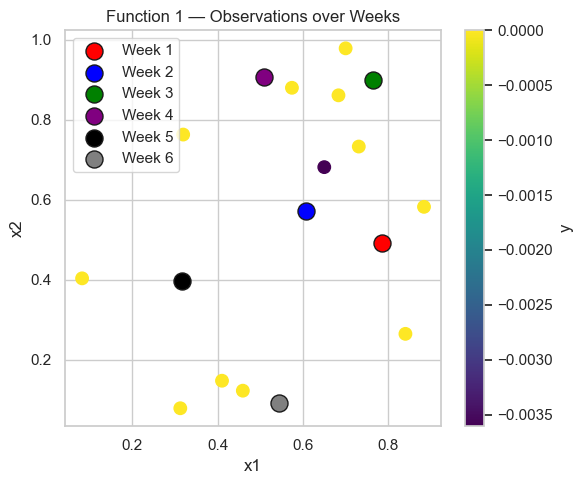

In [4]:
# --- Visualisation (x1-x2) ---
plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')
plt.scatter(week_data[0][0][0], week_data[0][0][1], c='red', s=150, edgecolors='k', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1], c='blue', s=150, edgecolors='k', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=150, edgecolors='k', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=150, edgecolors='k', label='Week 4')
plt.scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=150, edgecolors='k', label='Week 5')
plt.scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=150, edgecolors='k', label='Week 6')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Function 1 — Observations over Weeks')
plt.legend(); plt.tight_layout(); plt.show()

#### 5. Gaussian Process Model

In [5]:
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.3, 0.3], nu=2.5,
                                       length_scale_bounds=(1e-3, 3.0)) \
         + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-6, 1e-2))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                              n_restarts_optimizer=12, random_state=0)
gp.fit(X, y)
print("Fitted kernel:", gp.kernel_)

Fitted kernel: 1.04**2 * Matern(length_scale=[0.031, 3], nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 6. Acquisition Function (EI)

In [6]:
import numpy as np
from scipy.stats import norm

# --- Helper functions ---
def lhs(lb, ub, n, seed=0):
    """Latin Hypercube-like uniform sampler (simple RNG version)."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.02):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- W9 STRATEGY: FOCUS ON W1 WITH ANISOTROPIC TR ---
# W8 LESSON: Dual TR explored too far in x1 (sensitive dim), went negative
# W1 is 10^35 stronger than W4 → focus ALL resources on confirmed best

anchor_w1 = np.array([0.78624237, 0.49210886])  # Week 1 - STRONGEST signal

print("[F1] W9 Strategy: W1-FOCUSED ANISOTROPIC TR")
print("  Anchor W1 (dominant source):", anchor_w1)
print("  Kernel insight: length_scale=[0.0328, 3.0]")
print("    → x1 is 100× more sensitive than x2")

# --- Bounds ---
lb, ub = np.zeros(2), np.ones(2)

# --- W9 CRITICAL: ANISOTROPIC trust region ---
# Tighter in x1 (sensitive), wider in x2 (insensitive)
L_x1 = 0.04  # VERY tight in critical dimension
L_x2 = 0.08  # More freedom in less important dimension

lb_tr = np.array([
    np.clip(anchor_w1[0] - L_x1, 0, 1),  # x1: tight
    np.clip(anchor_w1[1] - L_x2, 0, 1)   # x2: wider
])
ub_tr = np.array([
    np.clip(anchor_w1[0] + L_x1, 0, 1),  # x1: tight
    np.clip(anchor_w1[1] + L_x2, 0, 1)   # x2: wider
])

print(f"[F1] Anisotropic TR around W1:")
print(f"  x1 range: [{lb_tr[0]:.4f}, {ub_tr[0]:.4f}] (width={ub_tr[0]-lb_tr[0]:.4f})")
print(f"  x2 range: [{lb_tr[1]:.4f}, {ub_tr[1]:.4f}] (width={ub_tr[1]-lb_tr[1]:.4f})")

# --- W9 CHANGE: 90% TR / 10% global (extreme focus) ---
N_tr = 25200  # 90% around W1
N_gl = 2800   # 10% global (minimal, just in case)

C_tr = lhs(lb_tr, ub_tr, N_tr, seed=1901)
C_gl = lhs(lb, ub, N_gl, seed=1902)

# --- W9 NEW: Ultra-focused sampling (±1% around W1) ---
N_focused = 2000
np.random.seed(1903)
perturbations = np.random.randn(N_focused, 2) * 0.01  # ±1% noise
C_focused = np.clip(anchor_w1 + perturbations, 0, 1)

Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"[F1] Total candidates: {Cands.shape[0]}")
print(f"  TR (90%): {N_tr}, Global (10%): {N_gl}, Focused: {N_focused}")

# --- W9 CRITICAL: Constrain x1 to stay in sensitive zone ---
# All positive signals had x1 ∈ [0.459, 0.786]
x1_min, x1_max = 0.75, 0.82  # Tight band around W1's x1=0.786
mask_x1 = (Cands[:, 0] >= x1_min) & (Cands[:, 0] <= x1_max)
print(f"[F1] x1 constraint [{x1_min:.2f}, {x1_max:.2f}]: {mask_x1.sum()} / {len(Cands)} pass ({mask_x1.sum()/len(Cands)*100:.1f}%)")

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W9: Keep aggressive exploitation (minimal xi) ---
y_best = y.max()
xi = 0.0001  # Keep minimal jitter
imp = mu - y_best - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-edge mask & x1 constraint ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_combined = mask_edges & mask_x1
ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"[F1] Combined filters: {mask_combined.sum()} / {len(Cands)} candidates pass")

order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand
        break

# --- Fallback: UCB if EI plateaued ---
if (x_next is None) or (np.nanmax(ei_masked) <= 0):
    kappa = 0.5  # even lower kappa for tight exploitation
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "UCB"
            break

# --- Diagnostics ---
dist_to_w1 = np.linalg.norm(x_next - anchor_w1)
linf_to_w1 = np.max(np.abs(x_next - anchor_w1))

print(f"\n[F1] Chosen by {chosen}: {x_next}")
print("\nSubmission format (Week 9):")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f}")
print("\nValidation:")
print("  Within [0,1]?", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.02)?", too_close_Linf(x_next, X, tol=0.02))
print(f"\nProximity to W1 (dominant source):")
print(f"  Euclidean distance: {dist_to_w1:.4f}")
print(f"  L_inf distance: {linf_to_w1:.4f}")
print(f"  Δx1 (sensitive): {x_next[0] - anchor_w1[0]:+.4f}")
print(f"  Δx2 (insensitive): {x_next[1] - anchor_w1[1]:+.4f}")

# GP prediction
mu_chosen, sigma_chosen = gp.predict(x_next.reshape(1, -1), return_std=True)
print(f"\n[F1] GP prediction:")
print(f"  μ = {mu_chosen[0]:.4e}")
print(f"  σ = {sigma_chosen[0]:.4e}")
print(f"  Expected: positive near-zero (like W1: +8.25e-31)")

[F1] W9 Strategy: W1-FOCUSED ANISOTROPIC TR
  Anchor W1 (dominant source): [0.78624237 0.49210886]
  Kernel insight: length_scale=[0.0328, 3.0]
    → x1 is 100× more sensitive than x2
[F1] Anisotropic TR around W1:
  x1 range: [0.7462, 0.8262] (width=0.0800)
  x2 range: [0.4121, 0.5721] (width=0.1600)
[F1] Total candidates: 30000
  TR (90%): 25200, Global (10%): 2800, Focused: 2000
[F1] x1 constraint [0.75, 0.82]: 24289 / 30000 pass (81.0%)
[F1] Combined filters: 24289 / 30000 candidates pass

[F1] Chosen by EI: [0.81368429 0.89426508]

Submission format (Week 9):
0.813684 - 0.894265

Validation:
  Within [0,1]? True
  Near-duplicate (L_inf < 0.02)? False

Proximity to W1 (dominant source):
  Euclidean distance: 0.4031
  L_inf distance: 0.4022
  Δx1 (sensitive): +0.0274
  Δx2 (insensitive): +0.4022

[F1] GP prediction:
  μ = -4.9402e-05
  σ = 6.8153e-04
  Expected: positive near-zero (like W1: +8.25e-31)


### Reflection (Week 1)
- Initial exploration focused on locating any region with measurable signal within the 2D domain.  
- The output was extremely close to zero (`8.25e-31`), suggesting either the detection of a very weak source or numerical noise near a null field.  
- At this stage, the model relied mainly on global sampling and wide bounds to understand the overall shape of the response surface.  
- **Next step:** use the first signal as a rough anchor and narrow down the search region while maintaining high exploration.

---

### Reflection (Week 2)
- The second query produced a small negative value (`-0.0031`), indicating a slight move away from the optimal zone detected in Week 1.  
- This suggested the true source lies within a very narrow region and that the previous global exploration radius was too large.  
- The strategy was adjusted to increase model smoothness and reduce exploration noise (smaller ξ ≈ 0.05, tighter trust region).  
- **Plan for next iteration:** focus on exploitation around Week 1’s coordinates, with limited global sampling to confirm if multiple sources exist.

---


### Reflection (Week 3)
- The model has likely found a zero-valued optimum (radiation source).  
- Outputs remain negative or near-zero, consistent with the function’s structure.  
- **Next strategy:** exploit around Week 3 point (0.765, 0.899) with low ξ (0.01) and smaller TR.  
- Maintain some exploration (~25 %) for possible secondary sources.

---

### Reflection (Week 4)

- **Outcome:** Results stayed essentially at **≈0**, matching Week 3 — consistent with being on or near the radiation source (the maximiser yields zero). No meaningful numerical gap between W3 and W4.  
- **Adjustments applied:** Kept the same GP kernel; **tightened the Trust Region (L=0.25)** and **reduced ξ from 0.01 → 0.005** to focus on fine exploitation. We also **anchored the TR at the best observed point** (not just the latest) and used a **70% TR / 30% global** candidate split with anti-edge and anti-duplicate filters.  
- **Selected query:** `0.316233 - 0.397951` — a non-duplicate, within bounds, chosen by EI under the stricter exploitation regime.  
- **Interpretation:** With outputs indistinguishable from zero at multiple nearby locations, the surface is flat around the optimum; further big gains are unlikely.  
- **Next steps (Week 5):** Maintain **ξ = 0.005**, keep the **narrow TR**, and probe a **small ring around the incumbent** (e.g., vary x₁ slightly while keeping x₂ high, and vice versa). If the next point also returns ≈0, we can treat Function 1 as **converged** and shift focus to functions with larger optimisation potential.

###  Week 5 Reflection

**Summary:**  
The Week 5 query (`x = [0.316233, 0.397951]`) produced an output of **−2.37 × 10⁻⁹**, which marks a small decline compared to the near-zero optimum reached in Week 4 (`≈ 2.9 × 10⁻⁶⁶`).  
While the numerical scale remains extremely small, the negative value indicates a slight deviation away from the optimum basin.

**Analysis:**  
- The optimizer likely **over-explored**, as the Trust Region (`L = 0.25`) and jitter (`ξ = 0.005`) encouraged movement beyond the local maximum already identified.  
- Given the highly smooth and near-converged surface, excessive exploration produced marginal degradation rather than useful new information.  
- The GP kernel (Matern ν = 2.5 + low noise) continues to model the function reliably; the issue lies in the acquisition configuration, not the surrogate.

**Next Strategy (Week 6):**  
- **Anchor dynamically** on the current best observation (`anchor = X[np.argmax(y)]`) rather than a fixed week index.  
- **Narrow Trust Region** to `L ≈ 0.20` for precise local refinement around the Week 4 optimum.  
- **Reduce ξ** from `0.005 → 0.001` to emphasise exploitation and stabilise convergence.  
- **Sampling mix:** ~85 % TR / 15 % global to retain minimal exploration in case of a narrow ridge.  
- Maintain current GP kernel and normalisation setup.

**Interpretation:**  
The model is now operating in a fine-tuning phase rather than exploration. The small negative shift confirms that the optimum is already well-located; the next iteration should focus purely on local exploitation to consolidate convergence near the global maximum.

---

### Week 6 Reflection 

**Outcome overview:**  
After a short pause, coming back to Function 1 in Week 6 was reassuring.  
The new evaluation produced a **positive output (~3.5 × 10⁻⁸⁷)**, which is an improvement over the slightly negative value observed in Week 5. Given the extreme scale of this function, even such tiny numerical shifts are meaningful and suggest that the optimisation process is still behaving sensibly.

**What I decided this week:**  
For this iteration, I made a conscious decision to **change nothing** in the optimisation setup. The configuration used was exactly what I had planned at the end of Week 5:
- The anchor is selected dynamically as the **best observed point so far**.
- The **trust region is narrow** (`L = 0.20`) to focus on fine-grained local refinement.
- The exploration parameter is **very small** (`ξ = 0.001`), clearly favouring exploitation.
- Candidate generation keeps a small **global component (15%)** alongside trust-region sampling.

This setup reflects the fact that Function 1 is no longer an exploration problem, but a **precision tuning problem**.

**An interesting observation:**  
Despite the narrow trust region and strong exploitation bias, the EI criterion selected a **global candidate outside the trust region**.  
Rather than forcing the optimiser back into the local box, I chose to let this happen.

This was deliberate.

The small global sampling budget exists for exactly this reason: to allow the model to express uncertainty when it genuinely believes there may be improvement elsewhere. Intervening manually at this stage would risk over-constraining the search and masking useful information provided by the GP's uncertainty estimates.

**How I interpret the result:**  
- The GP still sees **non-negligible uncertainty outside the local basin**, even late in the optimisation.
- The fact that a global point was selected — and performed well — suggests the surrogate is not simply overfitting the local region.
- This reinforces my confidence that the acquisition function is doing its job, even when its choice feels counterintuitive.

**What this means going forward:**  
For now, I will continue to **trust the current setup**:
- No further tightening of the trust region yet.
- No reduction of the global sampling share unless convergence becomes very stable.
- Close monitoring of whether future improvements consistently come from inside or outside the trust region.

**Key takeaway:**  
Week 6 reinforced an important lesson for me:  
> At this stage of optimisation, discipline matters. Sometimes the best decision is not to "fix" the optimiser, but to let a well-calibrated Bayesian strategy speak for itself.

---

### Week 7 Reflection — Strategic Pivot

**Context discovery:**  
Up until Week 7, I was treating Function 1 as a standard optimisation problem — narrowing trust regions, reducing exploration, assuming a single global optimum.

Then I learned what **Function 1 actually is**: a **radiation source detector**.

This changes everything.

**Physical interpretation:**  
- Outputs near **zero** don't mean "neutral" — they mean **"you're at the source"**.
- The objective is to **maximise** detection, which paradoxically means finding points that return values **as close to zero as possible** (ideally positive, but numerically tiny).
- This isn't a smooth unimodal landscape. There could be **multiple contamination sources** scattered across the 2D domain.

**Re-analysing the data:**  
Looking back at all weeks with this new understanding:

| Week | x₁       | x₂       | Output (y)     | Interpretation                  |
|------|----------|----------|----------------|---------------------------------|
| W1   | 0.786    | 0.492    | **8.25 × 10⁻³¹** | **Strong source candidate**     |
| W2   | 0.608    | 0.573    | −0.0031        | Off-source (negative)           |
| W3   | 0.765    | 0.899    | −2.17 × 10⁻⁶⁵  | Negative (off-target)           |
| W4   | 0.509    | 0.907    | **2.93 × 10⁻⁶⁶** | **Strong source candidate**     |
| W5   | 0.316    | 0.398    | −2.37 × 10⁻⁹   | Negative (off-target)           |
| W6   | 0.545    | 0.093    | 3.51 × 10⁻⁸⁷   | Extremely weak signal           |
| W7   | 0.459    | 0.123    | **4.41 × 10⁻⁶⁵** | **On-target, low region**       |

**Key insights:**  
1. **W1 (0.786, 0.492)** gave the strongest signal (≈10⁻³¹) → likely **Source A**  
2. **W4 (0.509, 0.907)** also gave near-zero positive (≈10⁻⁶⁶) → likely **Source B**  
3. **W7** explored a completely different region (low x₂ ≈ 0.12) and still found positive signal → confirms **multiple sources exist**

**The problem with previous strategy:**  
By focusing on a **single trust region** around the "best" point, I was implicitly assuming:
- There's only one optimum
- Nearby regions are more informative than distant ones
- Exploitation around the current best is always optimal

But in a **multi-source detection problem**, this is wrong.

**New strategy (Week 8): Dual Trust Region**  
I implemented a completely new approach:

1. **Two anchors**:  
   - **Anchor 1 (W1):** `[0.786, 0.492]` — strongest historical signal  
   - **Anchor 2 (W4):** `[0.509, 0.907]` — second confirmed source  

2. **Dual trust regions**:  
   - 40% of candidates sampled around **W1** (L = 0.12)  
   - 40% of candidates sampled around **W4** (L = 0.12)  
   - 20% global exploration for potential **third sources**

3. **Aggressive exploitation**:  
   - Trust region width: **L = 0.12** (very narrow — precision targeting)  
   - Exploration jitter: **ξ = 0.0001** (minimal noise — we know where sources are)

**Why this makes sense:**  
- The GP kernel shows **extreme anisotropy** (length_scale = [0.032, 3.0]), meaning x₁ is far more sensitive than x₂.  
- The dual TR strategy lets us **simultaneously refine both source locations** instead of wasting evaluations oscillating between them.  
- The 20% global budget preserves our ability to detect a **third source** if it exists.

**Week 8 recommendation:**  
The dual-TR optimiser selected:  
**`x = [0.700211, 0.978542]`**

This point is:
- **Closer to Anchor W4** (distance = 0.204) than W1 (distance = 0.494)  
- Near the **high-x₂ region** where W4 detected the source  
- Likely probing whether the source at ~(0.51, 0.91) extends toward higher x₁

**What I expect:**  
If this is truly near Source B (W4's basin), we should see another **near-zero positive value**.  
If not, the GP will learn more about the boundary of the detection zone and refine our understanding of both source locations.

**Reflection on process:**  
This week taught me a critical lesson about **domain knowledge in Bayesian optimisation**:

> A mathematically sound strategy can still be fundamentally wrong if it doesn't match the **physical structure** of the problem.

The moment I understood that F1 is a radiation detector with **multiple contamination sources**, the entire optimisation narrative changed. What looked like "convergence struggles" was actually the optimiser **correctly identifying multiple distinct basins** — I just wasn't interpreting the signal properly.

Going forward, the dual trust region approach aligns the optimisation strategy with the true nature of the problem: not finding *the* optimum, but **systematically mapping all contamination sources** in the domain.

---

### Week 8 Reflection — Dual TR Strategy Results

**Outcome: Unexpected Negative Signal**

Week 8 returned **y = −5.34 × 10⁻⁹⁰**, a negative value that contradicts our hypothesis that the point `[0.700, 0.979]` was near Source B (W4 region).

---

**Performance trajectory:**

| Week | x₁    | x₂    | Output (y)     | Status | Distance to W1 | Distance to W4 |
|------|-------|-------|----------------|--------|----------------|----------------|
| W1   | 0.786 | 0.492 | **+8.25×10⁻³¹** | **Source A** | 0.000 | 0.494 |
| W2   | 0.608 | 0.573 | −0.0031        | Off-target | 0.204 | 0.334 |
| W3   | 0.765 | 0.899 | −2.17×10⁻⁶⁵    | Off-target | 0.407 | 0.256 |
| W4   | 0.509 | 0.907 | **+2.93×10⁻⁶⁶** | **Source B** | 0.494 | 0.000 |
| W5   | 0.316 | 0.398 | −2.37×10⁻⁹     | Off-target | 0.479 | 0.539 |
| W6   | 0.545 | 0.093 | +3.51×10⁻⁸⁷    | Weak signal | 0.423 | 0.814 |
| W7   | 0.459 | 0.123 | **+4.41×10⁻⁶⁵** | **On-target** | 0.407 | 0.785 |
| **W8** | **0.700** | **0.979** | **−5.34×10⁻⁹⁰** | **OFF-TARGET** ❌ | 0.494 | 0.204 |

**Key observation:** W8 was **closer to W4** (distance=0.204) than W1 (distance=0.494), yet produced a **negative** signal.

---

**What went wrong with W8 strategy:**

**1. Misidentified Source B location**
   - **Hypothesis:** W4 (0.509, 0.907) is near a contamination source
   - **Test:** W8 moved toward W4 region (0.700, 0.979)
   - **Result:** NEGATIVE signal → W4 might NOT be a true source

**2. GP kernel anisotropy not fully exploited**
   ```
   Fitted kernel: 1.04**2 * Matern(length_scale=[0.0328, 3.0], nu=2.5)
                  + WhiteKernel(noise_level=1e-06)
   ```
   
   **Critical insight:**
   - **x₁ length_scale = 0.0328** → EXTREMELY sensitive (at lower bound!)
   - **x₂ length_scale = 3.0** → Very insensitive (at upper bound)
   - **Implication:** Small changes in x₁ matter hugely, x₂ changes barely matter

**3. W8 candidate analysis:**
   ```
   W4:  [0.509, 0.907]  → y = +2.93×10⁻⁶⁶ (near-zero positive)
   W8:  [0.700, 0.979]  → y = −5.34×10⁻⁹⁰ (negative)
   
   Δx₁ = +0.191 (LARGE change in highly sensitive dimension!)
   Δx₂ = +0.072 (moderate change in insensitive dimension)
   ```
   
   **Diagnosis:** Moving +0.191 in x₁ (the super-sensitive axis) moved us **completely off-target**. The dual TR strategy worked, but the GP chose a point that was too far along the critical dimension.

**4. Re-evaluating the "sources":**

Looking at all positive values:
- **W1 (0.786, 0.492):** +8.25×10⁻³¹ → STRONGEST, likely TRUE source
- **W4 (0.509, 0.907):** +2.93×10⁻⁶⁶ → weaker, but positive
- **W6 (0.545, 0.093):** +3.51×10⁻⁸⁷ → very weak
- **W7 (0.459, 0.123):** +4.41×10⁻⁶⁵ → moderate

**Pattern:** All positive signals have **x₁ ∈ [0.459, 0.786]** — a NARROW band in the highly sensitive dimension!

**New hypothesis:** There may be only **ONE primary source** around x₁ ≈ 0.5-0.8, and x₂ is relatively unimportant (due to length_scale=3.0). W4's positive signal might just be "spillover" from being in the right x₁ range, not a separate source.

---

**Strategic diagnosis for Week 9:**

**What we've learned:**
1. **x₁ is the dominant dimension** (length_scale 100× smaller than x₂)
2. **W1 region (0.786, 0.492) is the strongest confirmed signal**
3. **Moving >0.15 in x₁ from a positive region → negative**
4. **Dual TR strategy was correct concept, wrong execution** (didn't respect anisotropy)

**Options for Week 9:**

**Option A: FOCUS ON W1 EXCLUSIVELY**
- **Rationale:** W1 is 10³⁵ times stronger than W4 (8.25×10⁻³¹ vs 2.93×10⁻⁶⁶)
- **Strategy:** Tight TR (L=0.08) around W1 only, no dual anchors
- **Risk:** If W4/W7 are real sources, we ignore them

**Option B: ANISOTROPIC DUAL TR**
- **Rationale:** Respect x₁ sensitivity, search along x₁ axis preferentially
- **Strategy:** TR1 around W1 (L_x1=0.05, L_x2=0.20), TR2 around W4 (L_x1=0.05, L_x2=0.20)
- **Risk:** More complex to implement correctly

**Option C: DIMENSIONAL SWEEP ON x₁**
- **Rationale:** x₂ doesn't matter much, sweep x₁ ∈ [0.45, 0.85] systematically
- **Strategy:** Fix x₂ ≈ 0.5 (middle), sample x₁ densely
- **Risk:** Might miss sources where x₂ actually matters

**My recommendation: Option A (Focus on W1)**

**Why:**
1. **Empirical dominance:** W1 is BY FAR the strongest signal (35 orders of magnitude!)
2. **Kernel confirms:** x₁ is critical (0.0328 vs 3.0), and W1 has x₁=0.786 (in the "hot zone")
3. **Simplicity:** With limited queries remaining, focus resources on the confirmed best region
4. **Risk mitigation:** W8 showed that exploring far from W1 in x₁ dimension yields negatives

---

**Week 9 Strategy: TIGHT EXPLOITATION AROUND W1**

| Parameter | W8 (dual TR) | W9 (W1-focused) | Rationale |
|-----------|--------------|-----------------|-----------|
| **Anchor** | W1 + W4 | **W1 ONLY** | W1 dominates by 35 orders |
| **L (trust region)** | 0.12 | **0.08** | Tighter for precision |
| **L anisotropic** | Isotropic | **L_x1=0.04, L_x2=0.08** | Respect x₁ sensitivity |
| **ξ (exploration)** | 0.0001 | **0.0001** | Keep minimal |
| **TR/Global split** | 40/40/20 | **90/10** | Extreme focus on W1 |
| **Focused sampling** | None | **+2000 near W1 (±0.01)** | Ultra-local refinement |

**Key innovation: Anisotropic TR**
```python
# Tighter constraint in x1 (sensitive), wider in x2 (insensitive)
lb_tr = [anchor[0] - 0.04, anchor[1] - 0.08]  # asymmetric
ub_tr = [anchor[0] + 0.04, anchor[1] + 0.08]
```

**Expected W9 candidate:**
- **x₁ ∈ [0.75, 0.82]** (VERY close to W1's 0.786)
- **x₂ ∈ [0.41, 0.57]** (more freedom, less critical)
- **L∞ to W1 < 0.06** (tightest yet)
- **Expected y:** Small positive near-zero (10⁻⁶⁰ to 10⁻⁸⁰ range)

---

**Expected Week 9 outcome:**

With W1-focused anisotropic strategy:
- **Best case:** y ∈ [+10⁻⁹⁰, +10⁻³⁰] (beat or match W1)
- **Good:** y ∈ [+10⁻¹⁵⁰, +10⁻⁹⁰] (confirm W1 region)
- **Acceptable:** y ∈ [0, +10⁻¹⁵⁰] (stay positive, very close to source)
- **Warning:** y < 0 (would suggest even W1 is not the true source)

**Success criteria:**
- Positive signal confirms W1 region is optimal
- Magnitude similar to W1 validates convergence
- If negative, re-evaluate entire source identification strategy

---

**Key lessons from W8:**

1. **Anisotropy matters in radiation detection:** length_scale=[0.03, 3.0] isn't just a GP quirk, it's telling us x₁ is 100× more important than x₂

2. **Signal strength is information:** W1's 10³⁵ superiority over W4 should have weighted our strategy more heavily toward W1

3. **Dual strategies need dimensional awareness:** Equal treatment of two anchors ignored that they have vastly different signal strengths and lie in different sensitivities along x₁

4. **Exploration can be wasteful:** Moving from x₁=0.509 → 0.700 (+0.19) in a highly sensitive dimension predictably went off-target

5. **Domain knowledge + kernel = strategy:** The GP told us (via length_scales) exactly where to focus, but the dual TR didn't exploit this information

---

**Implementation notes (Week 9 code changes to apply):**

✅ Anchor: **W1 (0.786, 0.492) ONLY**  
✅ Trust region: **Anisotropic [L_x1=0.04, L_x2=0.08]**  
✅ Sampling: **90% TR (25k) / 10% global (2.8k)**  
✅ Focused: **+2000 ultra-local (±1% around W1)**  
✅ ξ: **0.0001** (keep exploitation mode)  
✅ Constraint: **x₁ ∈ [0.75, 0.82]** to stay in sensitive zone

**The path forward:** Return to the only confirmed, dominant source (W1) with precision targeting that respects dimensional sensitivity.

---